### 1. 理论知识

1. 非线性回归，即在线性回归的基础上增加了对自变量X的处理，在线性回归中y与x是线性关系，而在非线性回归中，x可以是对数，可以是指数，有指数回归，对数回归，多项式回归，双曲正切回归，Sigmoid函数等

### 2.数据准备

##### 2.1 导入数据集

In [1]:
# 导入模块
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# 处理数据集
ca_housing=fetch_california_housing()
X = pd.DataFrame(data=ca_housing.data, columns=ca_housing.feature_names)
y = pd.DataFrame(data=ca_housing.target, columns=["区平均售价"])

# 特征重命名
map_={
    'MedInc': '区收入中位数',
    'HouseAge': '区房屋年龄中位数',
    'AveRooms': '每户的平均房间数',
    'AveBedrms': '每户的平均卧室数',
    'Population': '区人口数',
    'AveOccup': '平每个家庭的成员数',
    'Latitude': '区组纬度',
    'Longitude': '区经度',
}
X=X.rename(columns=map_)
X

,区收入中位数,区房屋年龄中位数,每户的平均房间数,每户的平均卧室数,区人口数,平每个家庭的成员数,区组纬度,区经度
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


#### 2.2 数据处理

1. 对自变量X做各种非线性处理，这里举例对X做二次多项式处理。

2. 在机器学习中，**PolynomialFeatures**类用于生成多项式特征，将输入特征转换为指定次数的多项式。在这里，设置**degree=2**表示生成二次多项式特征，即原始特征的所有可能的二次组合。举个例子，假设原始特征为 [x1, x2]，使用PolynomialFeatures(degree=2)后，会生成如下特征：

    1. 1次特征： **[1, x1, x2]**
    2. 2次特征： **[1, x1, x2, x1^2, x1*x2, x2^2]**
这样，原始特征 [x1, x2] 就被转换成了包含原始特征及其二次组合的特征集合。

**注意！！一定要对数据进行归一化，统一量纲，不然梯度下降大概率无法收敛！！**

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer

# 添加多项式特征
poly = PolynomialFeatures(degree=2)  # 二次多项式特征
X_poly = poly.fit_transform(X)

# 数据归一化！！！！非常重要！！！！
X_1=Normalizer().fit_transform(X_poly)

# 添加补充列（已经Array化）
X_1 = np.hstack((X_1,(np.ones((len(X_poly), 1)))))

# 最后将y array化，方便后续计算，矩阵乘法@符号，和A.dot(B)形式都要求为array，否则只能用np.dot(A,B)
y=y.values

X_1.shape

(20640, 46)

### 3. 算法实现

#### 3.1 最小二乘法 ~ 正规方程

1. 非线性回归不能直接使用正规方程解法（无法保证是凸函数），如下可见损失函数极大

In [3]:
from sklearn.metrics import mean_squared_error as mse

# 最小二乘法~正规方程求解：核心公式！！！！！
A = np.linalg.inv(X_1.T@X_1)@X_1.T@y # np.linalg.inv 求矩阵的逆，但是假如矩阵不可逆？

# 损失函数写法1
loss = (1/2) * np.sum((np.dot(X_1,A)-y)**2) / X.shape[0]
print("Loss值：",loss)

# 损失函数写法2
error=np.dot(X_1,A)-y
cost = (1 / 2) * np.dot(error.T, error) / X.shape[0]
print("cost",cost)

# MSE均方误差
pred_y = np.dot(X_1,A)
print("MSE均方误差：",mse(pred_y,y))

Loss值： 0.3560030877883593
cost [[0.35600309]]
MSE均方误差： 0.7120061755767186


#### 3.2 梯度下降

**梯度下降思想**：
1. 损失函数：**J(A) = (1/2n) · ( X·A − Y )^2 ，** ,（1/2n中的2是为了求导后使得前面的系数为1），此时A是自变量，X是常量。

2. 对A求梯度，可得ΔA ,A = A - ΔA（往梯度的反方向迭代时），损失函数可获取最小值，**ΔA = gradient = (1/n)·X.T·(X·A - Y)**



In [4]:

# 设置迭代次数与下降速率
n_iterations = 1000
learning_rate = 0.01

# 设置随机初始 A
loss_his=[]
A = np.random.rand(X_1.shape[1], 1)
n = X_1.shape[0]

for _ in range(n_iterations):

    # 梯度求解：核心公式！！！！！
    gradients = X_1.T @ (X_1 @ A - y) / n
    
    # 参数迭代
    A = A - learning_rate * gradients
    
    # 求损失值
    loss=mse(X_1@A,y)
    loss_his.append(loss)

    

# MSE均方误差
pred_y = np.dot(X_1,A)
print("MSE均方误差：",mse(pred_y,y))

MSE均方误差： 1.3294330944527488


<Axes: >

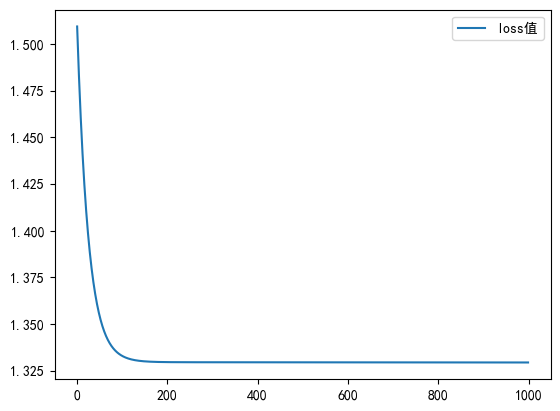

In [5]:
# 绘图设置
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'

pd.DataFrame(data=loss_his,columns=["loss值"]).plot()

### 4. 总结

1. 正规方程是线性回归的封闭解，一般不用于非线性回归

2. 非线性回归由于关系是非线性的，所以一般采用梯度下降等迭代法来求解。(一定要归一化)